In [3]:
import torch
import torch.optim as optim
import torch.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import time 
import torchvision.models as models
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
data_pathway  = "./dataset"

In [6]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
data = datasets.ImageFolder(root = data_pathway , transform =image_transform)

In [8]:
data

Dataset ImageFolder
    Number of datapoints: 2300
    Root location: ./dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
dir(data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_is_protocol',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [10]:
class_name = data.classes
class_name

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [11]:
total_data_size  = len(data)
total_data_size

2300

In [12]:
train_data_size = int(0.75*total_data_size)
test_data_size = total_data_size - train_data_size

train_data_size , test_data_size

(1725, 575)

In [13]:
train_dataset , val_dataset = random_split(data  , [train_data_size , test_data_size])

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset , batch_size = batch_size ,shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = batch_size , shuffle = True)

In [15]:
train_loader

In [16]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [17]:
labels[1]

tensor(5)

In [18]:
images[1].shape

torch.Size([3, 224, 224])

In [19]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


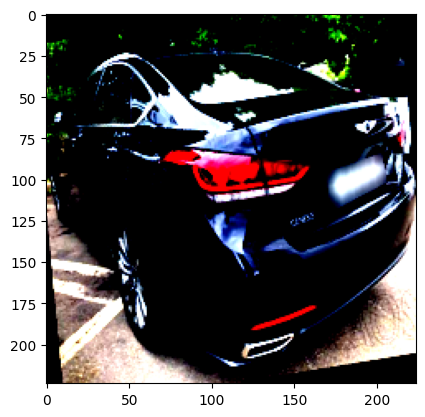

In [20]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

In [41]:
class CarClassifierCNN(nn.Module):
    def __init__(self , num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels =3 , out_channels = 16 , kernel_size = 3 , stride = 1 , padding = 1), #(16 , 224 ,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 112 , 112)
            nn.Conv2d(in_channels =16 , out_channels = 32 , kernel_size = 3 , stride = 1 , padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 56 , 56)
            nn.Conv2d(in_channels = 32  , out_channels = 64 , kernel_size = 3 , stride = 1 , padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 28 , 28)
            nn.Flatten(), 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Linear(512 , num_classes)
        )

    def forward(self , x):
        return self.network(x)
        

In [46]:


def train_model(model, criterion, optimizer, epochs=5):
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num , (images , labels) in enumerate(train_loader):
            images  = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs , labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()*images.size(0)

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        #validation
        model.eval()
        all_labels  = []
        all_predicted = []
        correct = 0 
        total = 0
        with torch.no_grad():
            for images , labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _ , predicted = torch.max(outputs.data , 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

        print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")




    end_time = time.time()

    print(f"execution_time :{end_time - start_time} seconds")

    return all_labels , all_predicted

In [47]:
num_classes = len(class_name)

model = CarClassifierCNN(num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters() , lr = 0.001)
criterion = nn.CrossEntropyLoss()

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.73
Batch: 30, Epoch: 1, Loss: 1.83
Batch: 40, Epoch: 1, Loss: 1.59
Batch: 50, Epoch: 1, Loss: 1.62
Epoch [1/10], Avg Loss: 1.7837
*** Validation Accuracy: 43.48% ***
Batch: 10, Epoch: 2, Loss: 1.36
Batch: 20, Epoch: 2, Loss: 1.70
Batch: 30, Epoch: 2, Loss: 1.09
Batch: 40, Epoch: 2, Loss: 1.20
Batch: 50, Epoch: 2, Loss: 1.14
Epoch [2/10], Avg Loss: 1.2956
*** Validation Accuracy: 49.39% ***
Batch: 10, Epoch: 3, Loss: 1.30
Batch: 20, Epoch: 3, Loss: 1.20
Batch: 30, Epoch: 3, Loss: 1.32
Batch: 40, Epoch: 3, Loss: 1.23
Batch: 50, Epoch: 3, Loss: 0.77
Epoch [3/10], Avg Loss: 1.1618
*** Validation Accuracy: 52.00% ***
Batch: 10, Epoch: 4, Loss: 1.09
Batch: 20, Epoch: 4, Loss: 1.04
Batch: 30, Epoch: 4, Loss: 1.10
Batch: 40, Epoch: 4, Loss: 0.83
Batch: 50, Epoch: 4, Loss: 1.14
Epoch [4/10], Avg Loss: 1.0345
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 5, Loss: 0.91
Batch: 20, Epoch: 5, Loss: 1.06
Batch: 30, Epoch: 5, Loss: 0

### Model 2: CNN with Regularization

In [49]:
class CarClassifierCNN(nn.Module):
    def __init__(self , num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels =3 , out_channels = 16 , kernel_size = 3 , stride = 1 , padding = 1), #(16 , 224 ,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 112 , 112)
            nn.Conv2d(in_channels =16 , out_channels = 32 , kernel_size = 3 , stride = 1 , padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 56 , 56)
            nn.Conv2d(in_channels = 32  , out_channels = 64 , kernel_size = 3 , stride = 1 , padding = 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2 , padding = 0),#(16 , 28 , 28)
            nn.Flatten(), 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512 , num_classes)
        )

    def forward(self , x):
        return self.network(x)

In [51]:
num_classes = len(class_name)

model = CarClassifierCNN(num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters() , lr = 0.001 , weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 12.65
Batch: 20, Epoch: 1, Loss: 3.61
Batch: 30, Epoch: 1, Loss: 2.39
Batch: 40, Epoch: 1, Loss: 2.28
Batch: 50, Epoch: 1, Loss: 1.52
Epoch [1/10], Avg Loss: 7.9707
*** Validation Accuracy: 40.00% ***
Batch: 10, Epoch: 2, Loss: 1.77
Batch: 20, Epoch: 2, Loss: 1.68
Batch: 30, Epoch: 2, Loss: 1.31
Batch: 40, Epoch: 2, Loss: 1.38
Batch: 50, Epoch: 2, Loss: 1.44
Epoch [2/10], Avg Loss: 1.3914
*** Validation Accuracy: 45.22% ***
Batch: 10, Epoch: 3, Loss: 1.37
Batch: 20, Epoch: 3, Loss: 1.38
Batch: 30, Epoch: 3, Loss: 1.17
Batch: 40, Epoch: 3, Loss: 1.39
Batch: 50, Epoch: 3, Loss: 1.24
Epoch [3/10], Avg Loss: 1.2322
*** Validation Accuracy: 49.39% ***
Batch: 10, Epoch: 4, Loss: 1.21
Batch: 20, Epoch: 4, Loss: 1.26
Batch: 30, Epoch: 4, Loss: 1.24
Batch: 40, Epoch: 4, Loss: 1.41
Batch: 50, Epoch: 4, Loss: 1.21
Epoch [4/10], Avg Loss: 1.1753
*** Validation Accuracy: 49.57% ***
Batch: 10, Epoch: 5, Loss: 1.18
Batch: 20, Epoch: 5, Loss: 1.23
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [52]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Amal/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 35.6MB/s]


1280